In [704]:
import pandas as pd  #data
import numpy as np   #math
from scipy import stats   #stats
from datetime import datetime
from math import factorial, sqrt #needed to count factorials
import mpmath #to hold large numbers in memory

import seaborn as sns  #visualization
import matplotlib.pyplot as plt   #visualization
%matplotlib inline


In [180]:
data = pd.read_csv('pd_toy_data.csv', delimiter = ';')

In [181]:
data.columns

Index(['customer_id', 'reporting_date', 'default_moment', 'intodefault',
       'mrating', 'PD'],
      dtype='object')

In [182]:
for col in data.columns:
    missing = data[col].isnull().sum()
    if missing>0:
        print("There are {} missing observations in column '{}'".format(missing,col))

There are 520221 missing observations in column 'default_moment'


<p>There are over 520k missing observations in 'default moment' column</p>
<p>We need to check if this is consistent with the number of defaults</p>

In [183]:
len(data.loc[(data['default_moment'].isnull()) & (data['intodefault']==1)])

0

<p>There are not any observations with missing default moment and intodefault = 1</p>
<p>The next thing to check are the duplicates in customer_id column</p>
<p>Existing duplicates suggest that the datas contain multiple assesments for the same customers</p>

In [184]:
print("Number of customers: "+str(len(data['customer_id'].unique())))
print("And {} observations".format(len(data)))
print("On average, every customer was assessed {} times".format(int(len(data)/len(data['customer_id'].unique()))))
print("There were {} defaulting customers".format(len(data.loc[data['intodefault']==1,'customer_id'].unique())))

Number of customers: 37716
And 551089 observations
On average, every customer was assessed 14 times
There were 3994 defaulting customers


We have to deal with the reporting and default date
1. As there are many ratings assigned for the same customers
2. We can assume that the PD means the probability of a default in the next 12 months
3. So we can compare reporting date with default date
4. If the difference is bigger than 12 months, default = 0, else 1

In [185]:
#we can fill na (no default) with the particular date being as far away from reporting date so the default will be = 0
data['default_moment'].fillna("31-12-2020",inplace=True)

In [186]:
#months are expressed as single digit, we have to add a leading 0 so the datatime could parse the string

#define function to add leading 0 to the month number
def add_zero(x):
    day, month, year = x.split("-")
    if len(month)<2:
        month = "0"+month
    return day+"-"+month+"-"+year

#convert string default moment to datetime
data['default_moment'] = data['default_moment'].apply(add_zero)
data['default_datetime'] = data['default_moment'].apply(lambda x: datetime.strptime(x,"%d-%m-%Y"))

#the same with the reporting date
data['reporting_date'] = data['reporting_date'].apply(add_zero)
data['reporting_datetime'] = data['reporting_date'].apply(lambda x: datetime.strptime(x,"%d-%m-%Y"))

In [187]:
#calculate the difference between default and reporting time
data['time_difference'] = data['default_datetime'] - data['reporting_datetime']
data['time_difference'] = data['time_difference'].apply(lambda x: x.days)

In [188]:
#if the calculated difference > one year => there is no default; else default = 1
data['default'] = data['time_difference'].apply(lambda x: 1 if x<=365 else 0)

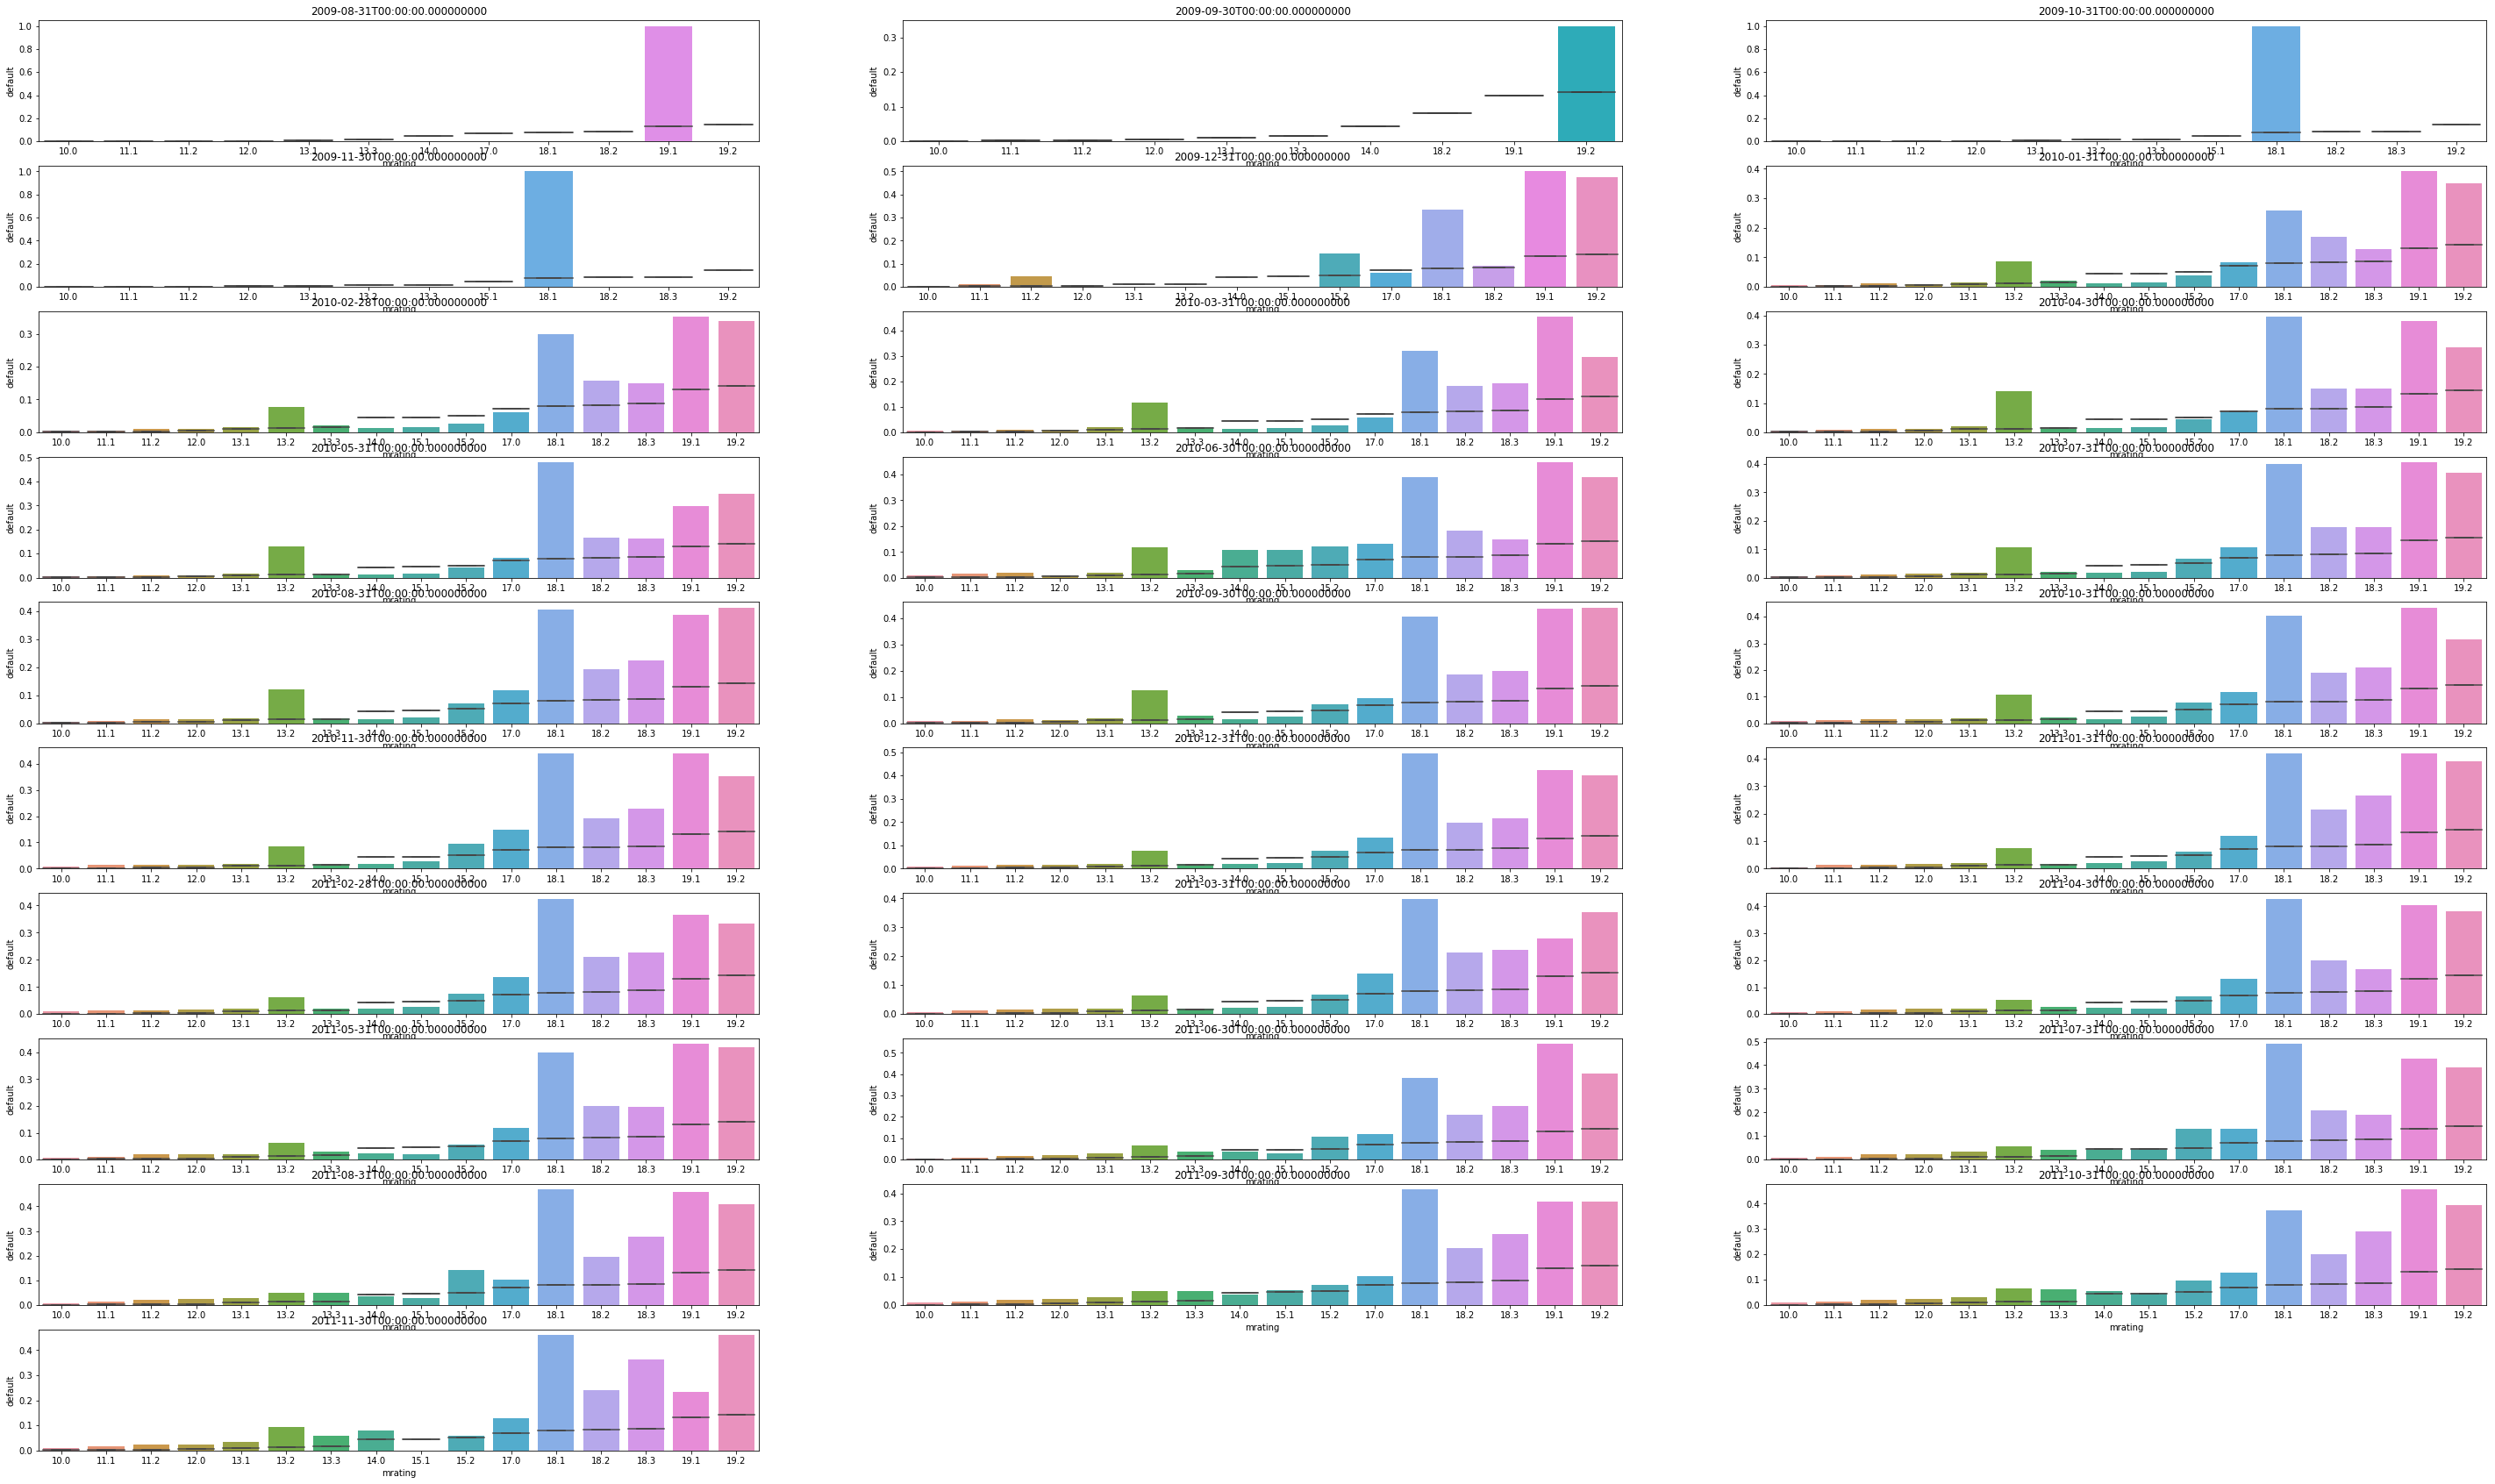

In [189]:
#now we will plot the observed default rated vs PDs in each month to visually asses model calibration 
f = plt.figure(figsize=(50,30))
for i, date in enumerate(sorted(data['reporting_datetime'].unique())):
    data_sub = data.loc[data['reporting_datetime']==date]
    ax = f.add_subplot(10, 3, i+1)
    ax = sns.boxplot(x='mrating',y='PD',data=data_sub)
    ax.xlabel = None
    new_df = pd.DataFrame(data_sub.groupby('mrating').sum()['default']/data_sub.groupby('mrating').count()['default'])
    ax = sns.barplot(x = new_df.index.values,y = new_df['default'])
    ax.xlabel = None
    plt.title(date)

<p>It looks like defaults occur more often in certain groups than indicated by PD</p>
<p>Also it looks like there are too few observations for rating issued in 2009</p> 

In [190]:
#We need to confirm the low number of observations from 2009
data['reporting_date'].value_counts()

31-10-2011    29212
30-11-2011    29057
31-08-2011    29013
30-09-2011    28811
31-07-2011    28574
30-06-2011    28212
31-05-2011    27870
30-04-2011    27397
31-03-2011    26789
28-02-2011    26407
31-01-2011    25960
31-12-2010    25334
30-11-2010    24443
31-10-2010    24165
30-09-2010    22357
31-08-2010    22084
31-07-2010    21471
30-06-2010    19147
31-03-2010    17469
30-04-2010    17363
31-05-2010    17354
28-02-2010    16054
31-01-2010    15912
31-12-2009      458
30-11-2009       53
31-10-2009       52
30-09-2009       38
31-08-2009       33
Name: reporting_date, dtype: int64

There are (obs : date):
<ul>
    <li>33  : Aug 2009</li>
    <li>38  : Sep 2009</li>
    <li>52  : Oct 2009</li>
    <li>53  : Nov 2009</li>
    <li>458 : Dec 2009</li>
</ul>
Comparing to over 15k from Jan2010 we can assume that analysing ratings from 2009 <br>
woulnt'd be informative so we will drop these observations

In [416]:
#drop observations from 2009
new_data = data.drop(data.loc[data['reporting_datetime'].apply(lambda x: True if x.year==2009 else False)==True].index)

<p>To test whether model calibration is statisticly correct we have to perform two tests:<br>
    Assuming binomial distribution we can perform binomial test</p>
    <img src="./test_binomial.png" width="500"/>
    
Or alternatively:
<img src="./test_binomial_2.png" width="500"/>
As we have multiple time periods we will perform tests for every period separately

<h1>Case I: binomial distribution</h1>

In [354]:
#newton symbol:
def newton(N,j):
    if (j == N) or (j ==0):
        return 1
    return factorial(N)//(factorial(j)*factorial(N-j)) #integer division to be able to count large numbers

#binomial test:
def binomial_test(N,PD=0,d=0):
    if type(N) == pd.Series:
        print(True)
        d = N[-1]
        PD = N[1]
        N = N[0]
    if d==0:
        return 0
    d_alpha = 0
    for j in range(0,d+1):
        #we need to use string representation as python can't handle large ints and float multiplication
        d_alpha += float((mpmath.mpf(newton(N,j))* (PD**j) * ((1-PD)**(N-j))))         
    #if d_alpha is greater then confidence level (let's say 95%) the PD is underestimated
    return d_alpha

In [378]:
results_df = pd.DataFrame(index = sorted(new_data['mrating'].unique()),columns = sorted(new_data['reporting_datetime'].unique()))
for date in sorted(new_data['reporting_datetime'].unique()):
    period_data = new_data.loc[new_data['reporting_datetime']==date]
    #As input data we need :
    #   1. number of observations in class (N)
    #   2. number of defaults in class (d)
    #   3. forecasted PD (PD)
    obs_count_per_rating = period_data['mrating'].value_counts()
    defaults_per_rating = period_data.groupby('mrating').sum()['default']
    pd_per_class = period_data.groupby('mrating').mean()['PD']
    observed_pd = defaults_per_rating/obs_count_per_rating
    data_to_test = pd.DataFrame({"N":obs_count_per_rating,"d":defaults_per_rating,"PD":pd_per_class})
    print("binomial tests for date:{}:".format(date))
    for rating_class in data_to_test.index.values:
        N, PD, d = data_to_test.loc[rating_class,['N','PD','d']]
        result = binomial_test(int(N),PD,int(d))
        results_df.loc[rating_class,date] = result

binomial tests for date:2010-01-31T00:00:00.000000000:
binomial tests for date:2010-02-28T00:00:00.000000000:
binomial tests for date:2010-03-31T00:00:00.000000000:
binomial tests for date:2010-04-30T00:00:00.000000000:
binomial tests for date:2010-05-31T00:00:00.000000000:
binomial tests for date:2010-06-30T00:00:00.000000000:
binomial tests for date:2010-07-31T00:00:00.000000000:
binomial tests for date:2010-08-31T00:00:00.000000000:
binomial tests for date:2010-09-30T00:00:00.000000000:
binomial tests for date:2010-10-31T00:00:00.000000000:
binomial tests for date:2010-11-30T00:00:00.000000000:
binomial tests for date:2010-12-31T00:00:00.000000000:
binomial tests for date:2011-01-31T00:00:00.000000000:
binomial tests for date:2011-02-28T00:00:00.000000000:
binomial tests for date:2011-03-31T00:00:00.000000000:
binomial tests for date:2011-04-30T00:00:00.000000000:
binomial tests for date:2011-05-31T00:00:00.000000000:
binomial tests for date:2011-06-30T00:00:00.000000000:
binomial t

In [379]:
results_df

,2010-01-31 00:00:00,2010-02-28 00:00:00,2010-03-31 00:00:00,2010-04-30 00:00:00,2010-05-31 00:00:00,2010-06-30 00:00:00,2010-07-31 00:00:00,2010-08-31 00:00:00,2010-09-30 00:00:00,2010-10-31 00:00:00,...,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,2011-11-30 00:00:00
10.0,0.999799,0.999713,0.999984,0.999986,0.999985,1,0.999996,0.999994,1,1,...,1,0.99999,0.99999,1,1,1,1,1,1,1
11.1,0.998618,0.998509,0.999995,0.999995,0.999993,1,0.999993,1,1,1,...,1,1,1,1,1,1,1,1,1,1
11.2,1,0.999998,1,1,0.999999,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
12.0,0.993292,0.992093,0.99694,0.999431,0.996503,0.803087,1,1,0.999987,1,...,1,1,1,1,1,1,1,1,1,1
13.1,0.996411,0.999787,1,1,0.999992,0.997149,0.999975,1,1,1,...,1,1,1,1,1,1,1,1,1,1
13.2,0.999989,0.999926,1,1,1,1,1,1,1,1,...,0.999998,1,0.999954,0.999999,0.999999,0.999976,0.999864,0.999887,0.999999,1
13.3,0.875583,0.89612,0.646343,0.341246,0.344304,0.933277,0.963934,0.873757,0.999707,0.981303,...,0.946826,0.933772,0.9993,0.999984,0.999999,1,1,1,1,1
14.0,5.56921e-10,1.14567e-08,7.79643e-09,2.01474e-08,1.38365e-08,0.998608,1.59485e-08,1.70996e-10,6.27609e-10,1.88041e-08,...,8.7924e-07,3.92351e-06,7.04252e-05,9.37523e-06,0.294256,0.411496,0.220766,0.327466,0.927191,0.999293
15.1,7.56922e-05,9.18659e-05,0.000229679,0.000251148,0.000133496,0.998765,0.00112351,0.000421023,0.00897407,0.0139084,...,0.0124816,0.00429503,0.00307265,0.00087743,0.3531,0.566539,0.307263,0.729473,0.627284,0
15.2,0.312273,0.0612367,0.0801768,0.425459,0.396529,1,0.896247,0.943966,0.947414,0.964853,...,0.957301,0.881689,0.864237,0.678545,0.983788,0.999205,0.99994,0.880449,0.987403,0.768915


In [403]:
for rating in results_df.index:
    print("PDs in class {} weren't underestimated in {} cases (out of 23)".format(rating,(results_df.loc[rating]<0.999).sum()))

PDs in class 10.0 weren't underestimated in 0 cases (out of 23)
PDs in class 11.1 weren't underestimated in 2 cases (out of 23)
PDs in class 11.2 weren't underestimated in 0 cases (out of 23)
PDs in class 12.0 weren't underestimated in 5 cases (out of 23)
PDs in class 13.1 weren't underestimated in 2 cases (out of 23)
PDs in class 13.2 weren't underestimated in 0 cases (out of 23)
PDs in class 13.3 weren't underestimated in 14 cases (out of 23)
PDs in class 14.0 weren't underestimated in 22 cases (out of 23)
PDs in class 15.1 weren't underestimated in 23 cases (out of 23)
PDs in class 15.2 weren't underestimated in 20 cases (out of 23)
PDs in class 17.0 weren't underestimated in 11 cases (out of 23)
PDs in class 18.1 weren't underestimated in 0 cases (out of 23)
PDs in class 18.2 weren't underestimated in 0 cases (out of 23)
PDs in class 18.3 weren't underestimated in 3 cases (out of 23)
PDs in class 19.1 weren't underestimated in 2 cases (out of 23)
PDs in class 19.2 weren't underesti

<p>It seems that in most rating grades PDs are significantly <u><b>underestimated</b></u></p>
<p>Probability that number of defaults is greater than predicted is above 99,9%<p>
<p>Model update should be considered</p>
<p>Answering the question: observed default rates are not within the expected range given the PD (there are too much defaults)</p>

<h1>Case II: correlated defaults</h1>

First we need to convert PDs provided in the file to conditional PDs
<p>Formula for K (Basel II): </p>
<p>Capital requirement (K) = [LGD * N [(1 - R)^-0.5 * G (PD) + (R / (1 - R))^0.5 * G (0.999)] - PD * LGD] * (1 - 1.5 x b(PD))^ -1 × (1 + (M - 2.5) * b (PD) </p>
<p>part converting the PD into conditional PD is the second square brackets</p>
<P>N [(1 - R)^-0.5 * G (PD) + (R / (1 - R))^0.5 * G (0.999)]</p>
where:
<ul>
    <li>N(X) - normal cumulative distribution function</li>
    <li>R - correlation coefficient (0.15)</li>
    <li>G(X) - inverse of normal cumulative distribution function</li>    
</ul>

In [498]:
def convert(x):
    rho = 0.15
    return stats.norm.cdf((1-rho)**(-0.5)*stats.norm.ppf(x) + (rho/(1-rho))**0.5*stats.norm.ppf(0.999))

In [499]:
#as our dataset is pretty big it will be faster to map PD not to convert each individually
mapper = dict(zip(new_data['PD'].unique(),convert(new_data['PD'].unique())))
new_data['CPD'] = new_data['PD'].map(mapper)

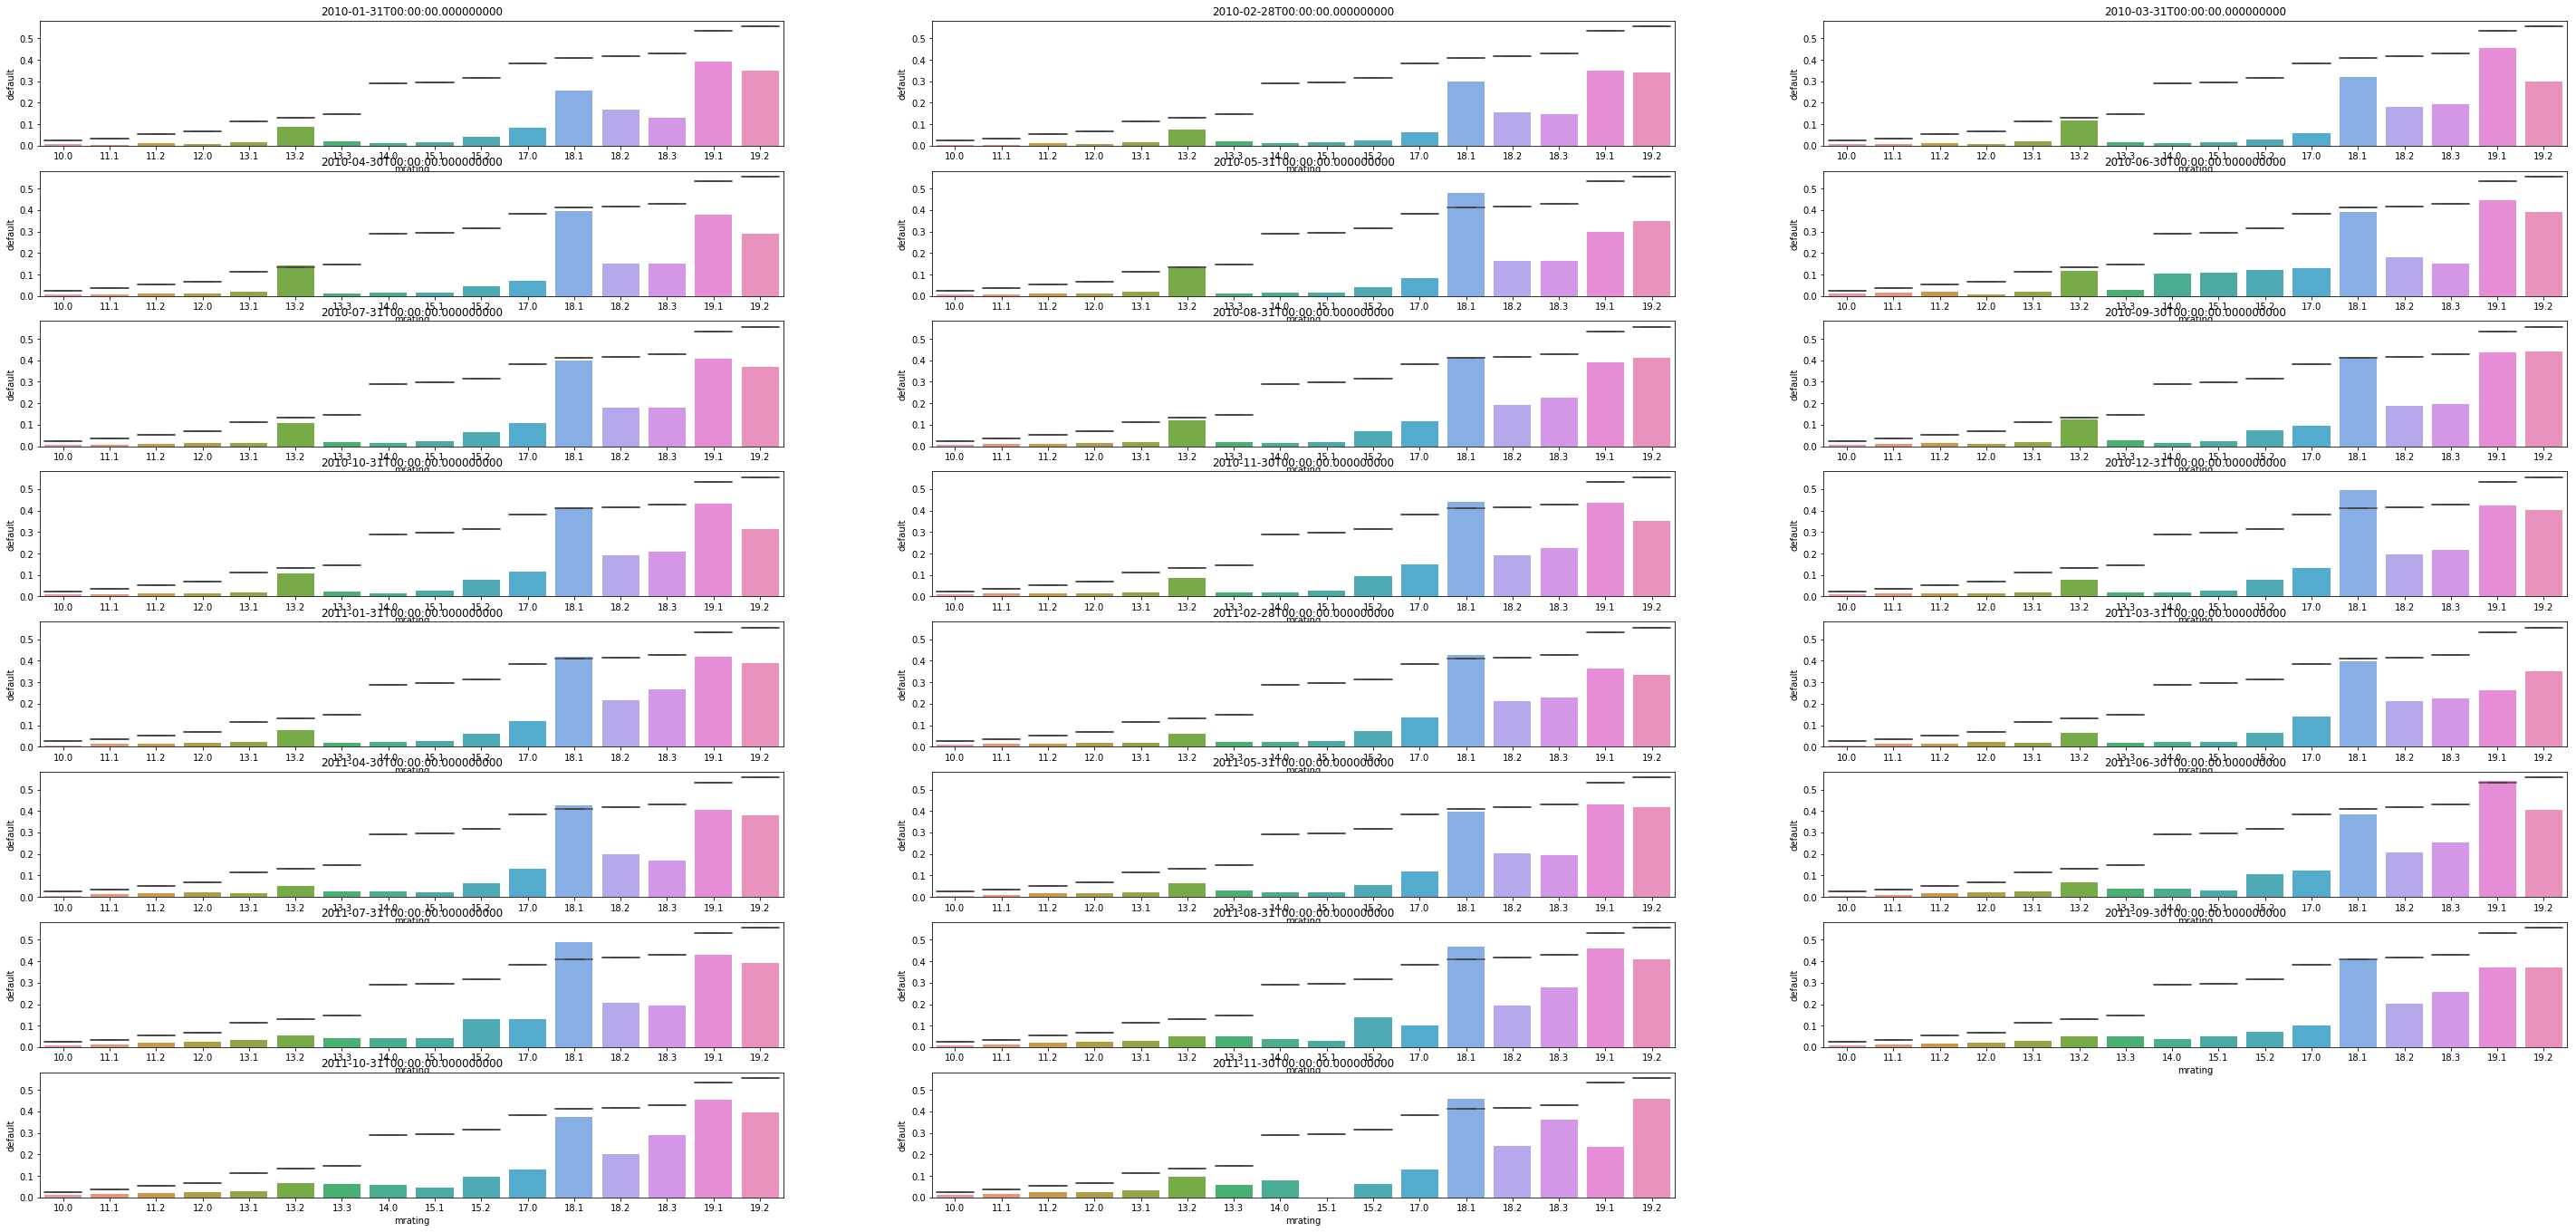

In [500]:
#visual check
f = plt.figure(figsize=(50,30))
for i, date in enumerate(sorted(new_data['reporting_datetime'].unique())):
    data_sub = new_data.loc[data['reporting_datetime']==date]
    ax = f.add_subplot(10, 3, i+1)
    ax = sns.boxplot(x='mrating',y='CPD',data=data_sub)
    ax.xlabel = None
    new_df = pd.DataFrame(data_sub.groupby('mrating').sum()['default']/data_sub.groupby('mrating').count()['default'])
    ax = sns.barplot(x = new_df.index.values,y = new_df['default'])
    ax.xlabel = None
    plt.title(date)

In most cases CPD are larger then observed ratio of defaults, probably we can state that they won't be significantly smaller

<h2>TESTs</h2>
<img src="./test_correlated_new.png" width = "750"/>

In [1063]:
def critical_k(n,cpd):
    conf = 0.999 
    x = stats.norm.ppf(cpd)
    rho = 0.15
    k = stats.norm.cdf((stats.norm.ppf(conf)*sqrt(rho) + x)/sqrt(1-rho)) * n
    return k

In [1066]:
results_df = pd.DataFrame(index = sorted(new_data['mrating'].unique()),columns = sorted(new_data['reporting_datetime'].unique()))
for date in sorted(new_data['reporting_datetime'].unique()):
    period_data = new_data.loc[new_data['reporting_datetime']==date]
    #As input data we need :
    #   1. number of observations in class (N)
    #   2. number of defaults in class (d)
    #   3. forecasted PD (PD)
    obs_count_per_rating = period_data['mrating'].value_counts()
    defaults_per_rating = period_data.groupby('mrating').sum()['default']
    pd_per_class = period_data.groupby('mrating').mean()['CPD']
    observed_pd = defaults_per_rating/obs_count_per_rating
    data_to_test = pd.DataFrame({"N":obs_count_per_rating,"d":defaults_per_rating,"CPD":pd_per_class})
    print("binomial tests for date:{}:".format(date))
    for rating_class in data_to_test.index.values:
        N, CPD, d = data_to_test.loc[rating_class,['N','CPD','d']]
        result = critical_k(N,CPD)
        results_df.loc[rating_class,date] = d>result

binomial tests for date:2010-01-31T00:00:00.000000000:
binomial tests for date:2010-02-28T00:00:00.000000000:
binomial tests for date:2010-03-31T00:00:00.000000000:
binomial tests for date:2010-04-30T00:00:00.000000000:
binomial tests for date:2010-05-31T00:00:00.000000000:
binomial tests for date:2010-06-30T00:00:00.000000000:
binomial tests for date:2010-07-31T00:00:00.000000000:
binomial tests for date:2010-08-31T00:00:00.000000000:
binomial tests for date:2010-09-30T00:00:00.000000000:
binomial tests for date:2010-10-31T00:00:00.000000000:
binomial tests for date:2010-11-30T00:00:00.000000000:
binomial tests for date:2010-12-31T00:00:00.000000000:
binomial tests for date:2011-01-31T00:00:00.000000000:
binomial tests for date:2011-02-28T00:00:00.000000000:
binomial tests for date:2011-03-31T00:00:00.000000000:
binomial tests for date:2011-04-30T00:00:00.000000000:
binomial tests for date:2011-05-31T00:00:00.000000000:
binomial tests for date:2011-06-30T00:00:00.000000000:
binomial t

In [1068]:
results_df.any()

2010-01-31    False
2010-02-28    False
2010-03-31    False
2010-04-30    False
2010-05-31    False
2010-06-30    False
2010-07-31    False
2010-08-31    False
2010-09-30    False
2010-10-31    False
2010-11-30    False
2010-12-31    False
2011-01-31    False
2011-02-28    False
2011-03-31    False
2011-04-30    False
2011-05-31    False
2011-06-30    False
2011-07-31    False
2011-08-31    False
2011-09-30    False
2011-10-31    False
2011-11-30    False
dtype: bool

<p>There are no classes in which number of actual defaults is greater </p>
<p>than critical value (k), which means that probabilities are not systematicaly undervalued </p>